In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import ppscore as pps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
import pygwalker as pyg
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math
import joblib
import pickle
import ipywidgets
from IPython.display import display


#### Load Indirect_Expenses worksheet

In [2]:
excel_file_path = '../budgetusd.xlsx'
sheet_name = "Indirect_Expenses"
df = pd.read_excel(excel_file_path, sheet_name=sheet_name, engine='openpyxl')
# Load the Excel file into a pandas DataFrame


In [3]:
# This function will remove decimal points

def round_up_numeric(value):
    if pd.notnull(value) and isinstance(value, (int, float)):
        return math.ceil(value * 100) / 100
    return value

df =  df.applymap(round_up_numeric)

In [4]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)


In [5]:
duplicate_cols = df.columns[df.columns.duplicated()]
print("Duplicate Columns:", duplicate_cols)

Duplicate Columns: Index([], dtype='object')


In [6]:
df.isnull().sum()

Total Revenue               0
Total Wages                 0
Maintenance                 0
Accounting Services         0
Admin Expenses              0
Utilities Expenses          0
Insuraces                   0
Systems & Communications    0
Transport                   0
Booking.com                 0
Marketing                   0
Comisiones POS              0
Total Indirect Costs        0
dtype: int64

#### Correlation Analysis

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


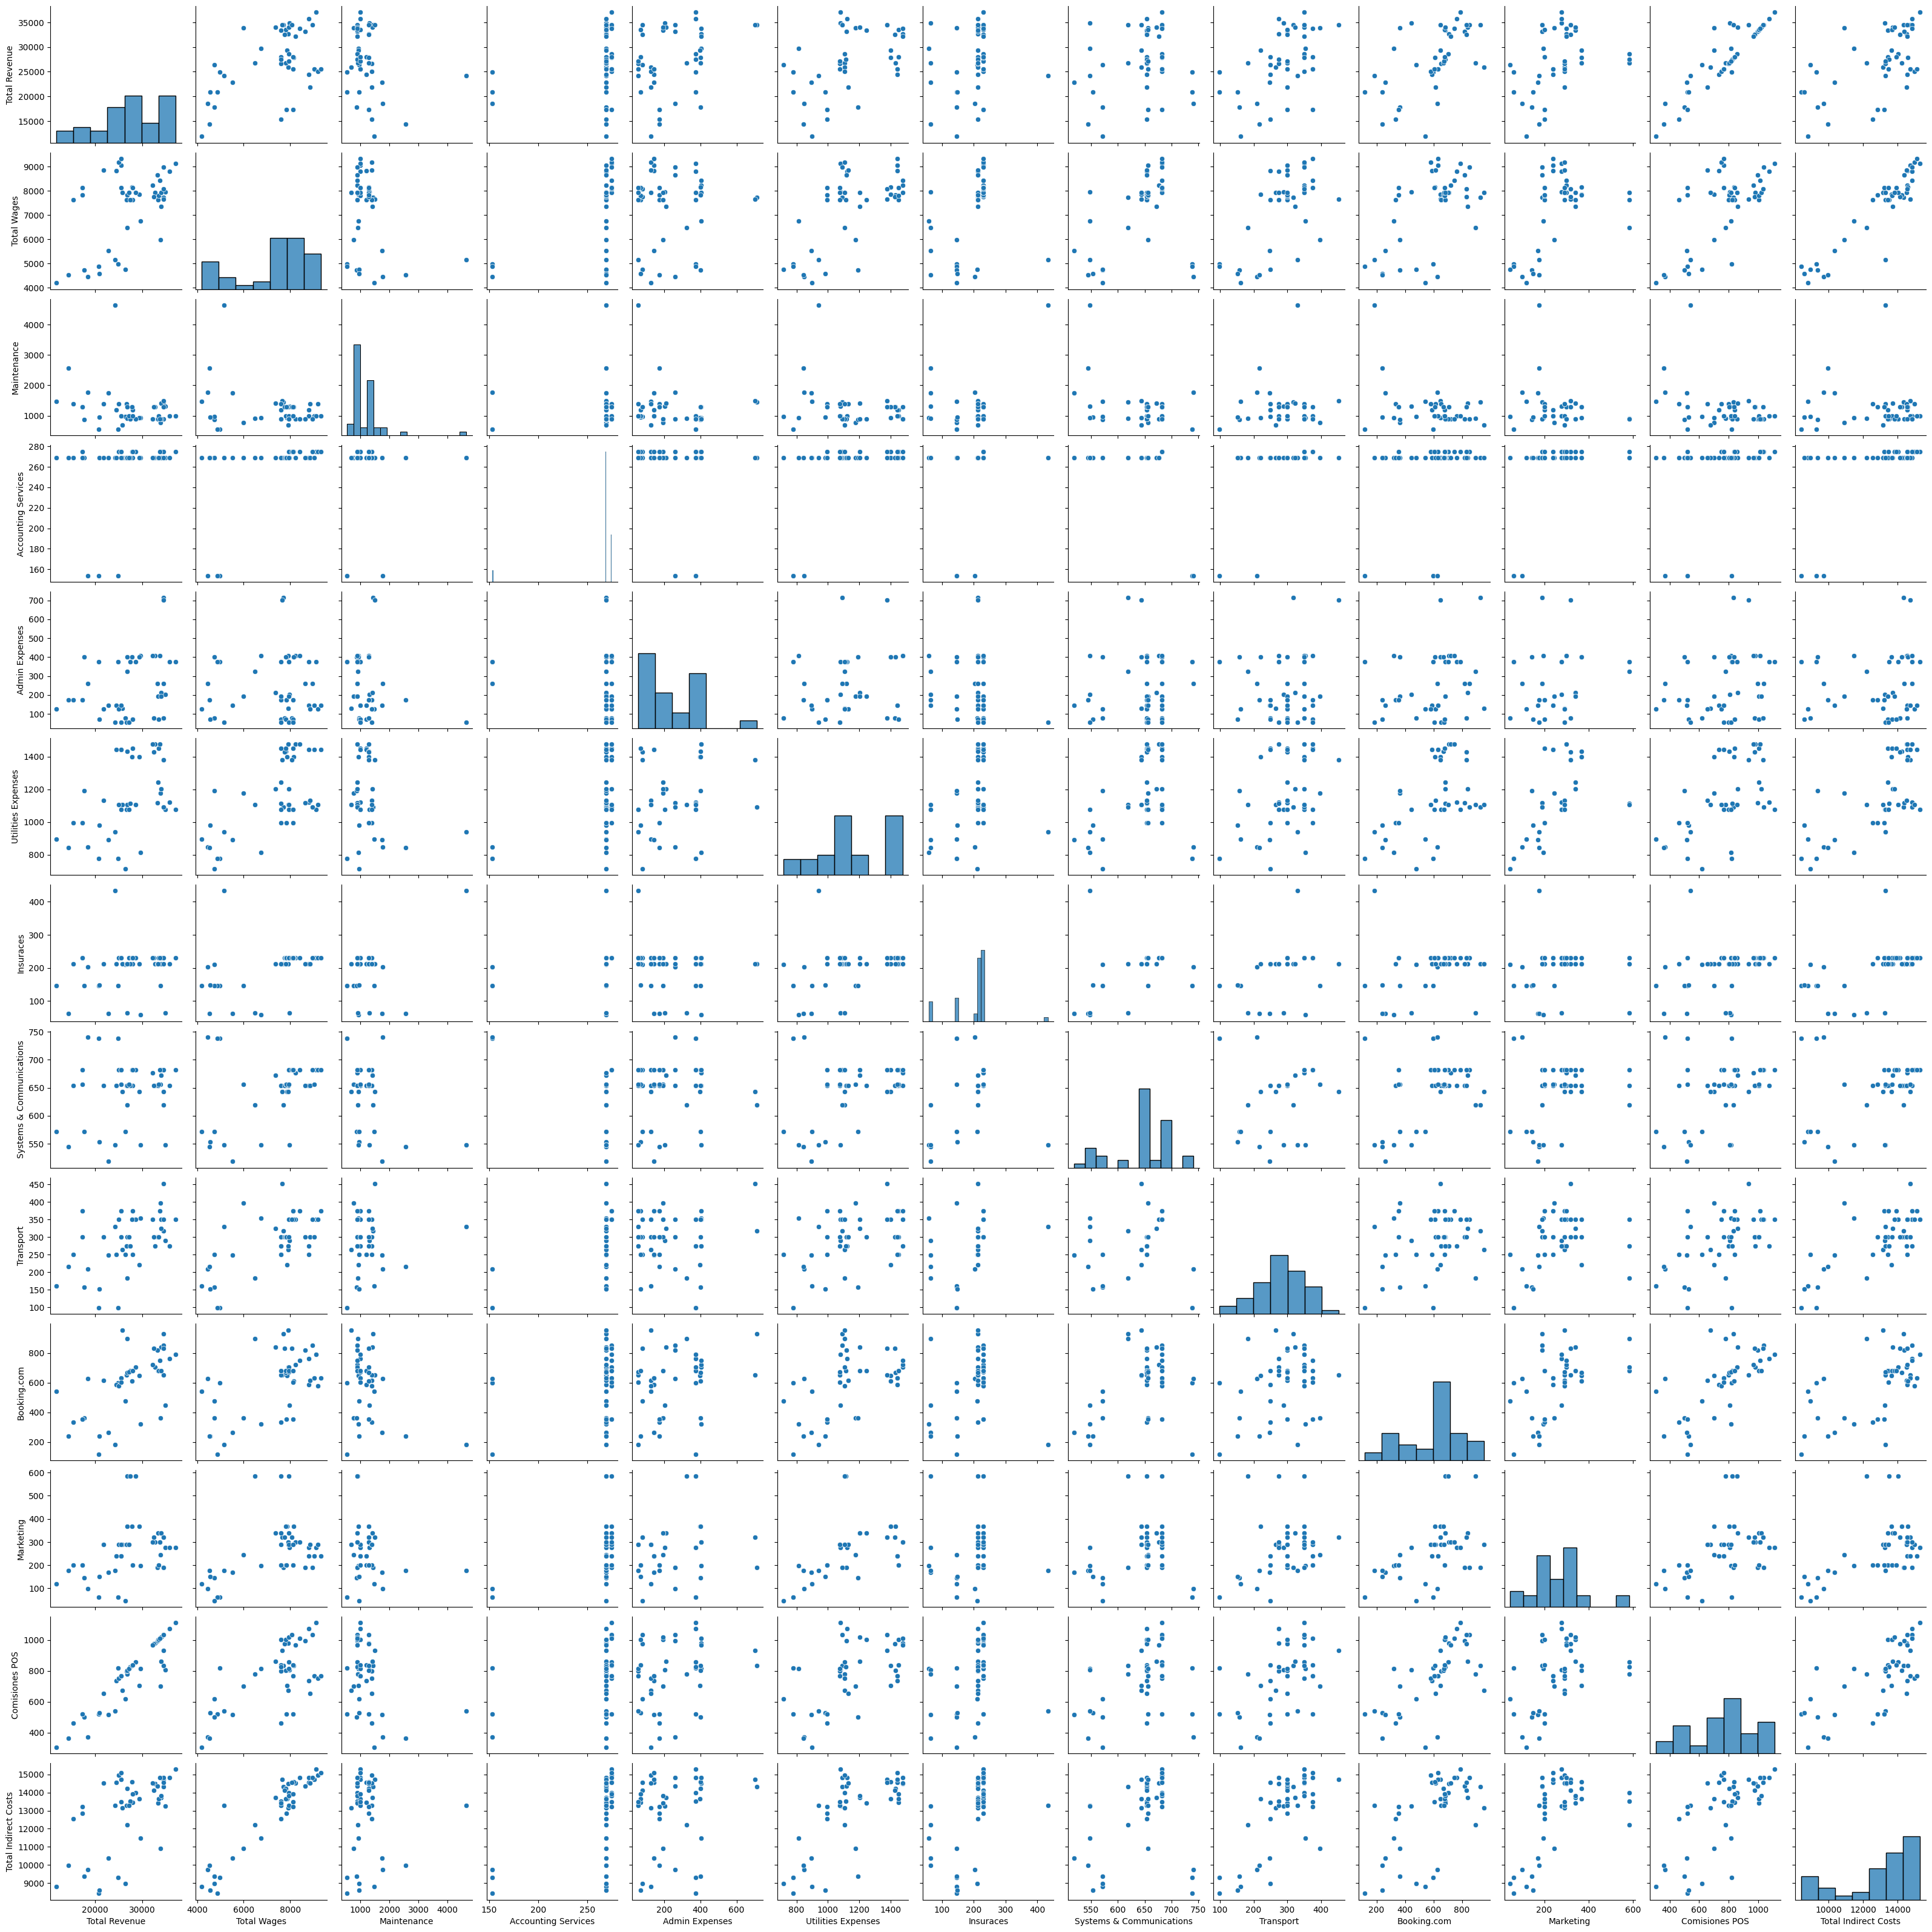

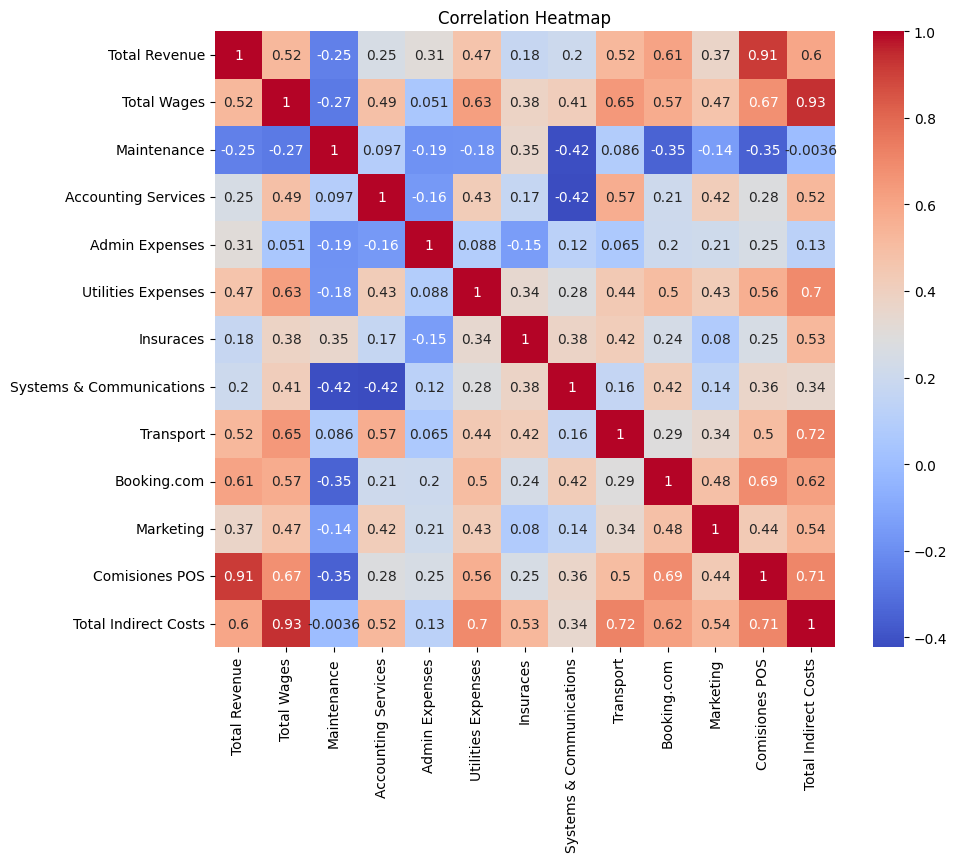

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots for numerical variables
sns.pairplot(df, vars=['Total Revenue', 'Total Wages', 
'Maintenance', 'Accounting Services', 'Admin Expenses', 'Utilities Expenses', 'Insuraces', 'Systems & Communications',
'Transport', 'Booking.com',	'Marketing', 'Comisiones POS', 'Total Indirect Costs'])
plt.show()

# Heatmap for numerical variable correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['Total Indirect Costs'], axis=1),
                                        df['Total Indirect Costs'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (38, 12) (38,) 
* Test set: (10, 12) (10,)


In [9]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [10]:
pipeline = pipeline_random_forest_reg()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [11]:
def feature_importance_tree_based_models(model, columns):
    """ Gets the mode, and the columns used to train the model
        we use the model.feature_importanes_ and columns to make a DataFrame that shows 
        the importance of each feature and then we print the features name and its relative 
        importance order, followed by a barplot indicating the importance
        """ 
    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Features': columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    best_features = df_feature_importance['Features'].to_list()

    # Print the most important features and plot the feature importance
    print(f"* These are the {len(best_features)} most important features in descending order. The model was trained on them:")
    print(df_feature_importance['Features'].to_list())

    df_feature_importance.plot(kind='bar', x='Features', y='Importance')
    plt.show()

* These are the 4 most important features in descending order. The model was trained on them:
['Total Wages', 'Insuraces', 'Transport', 'Marketing']


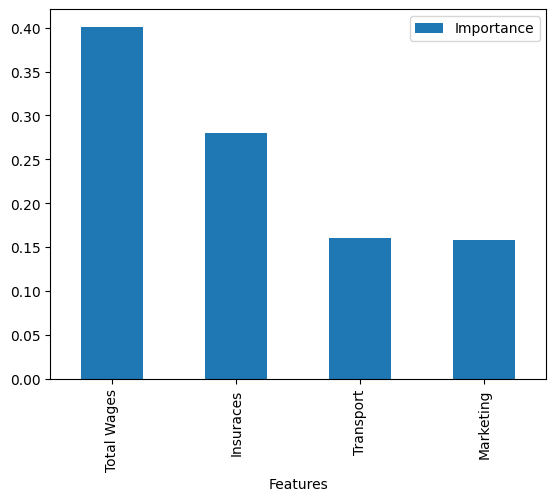

In [12]:
best_features = feature_importance_tree_based_models(model = pipeline['model'],
                                     columns = X_train.columns[pipeline['feature_selection'].get_support()])

In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.972
Mean Absolute Error: 239.678
Mean Squared Error: 110412.375
Root Mean Squared Error: 332.284


* Test Set
R2 Score: 0.903
Mean Absolute Error: 509.006
Mean Squared Error: 360153.008
Root Mean Squared Error: 600.127




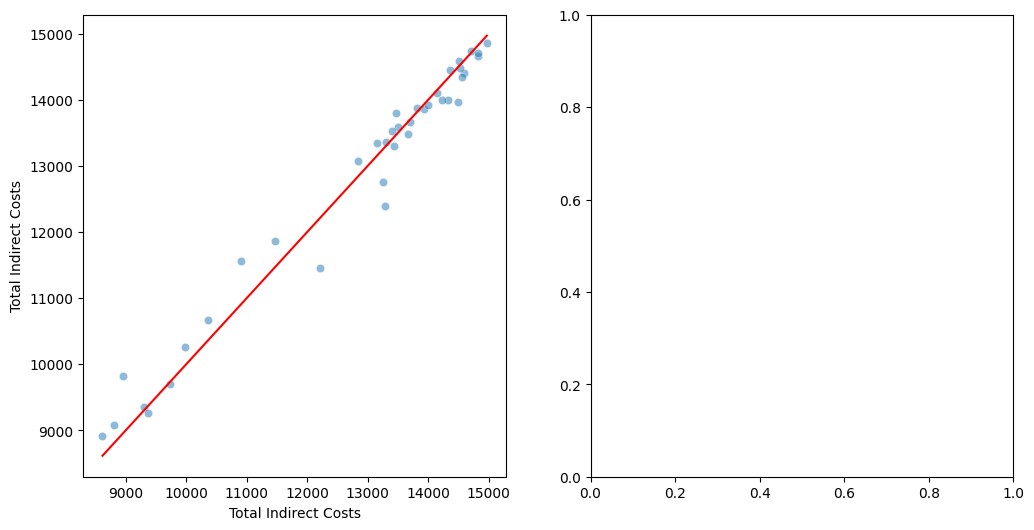

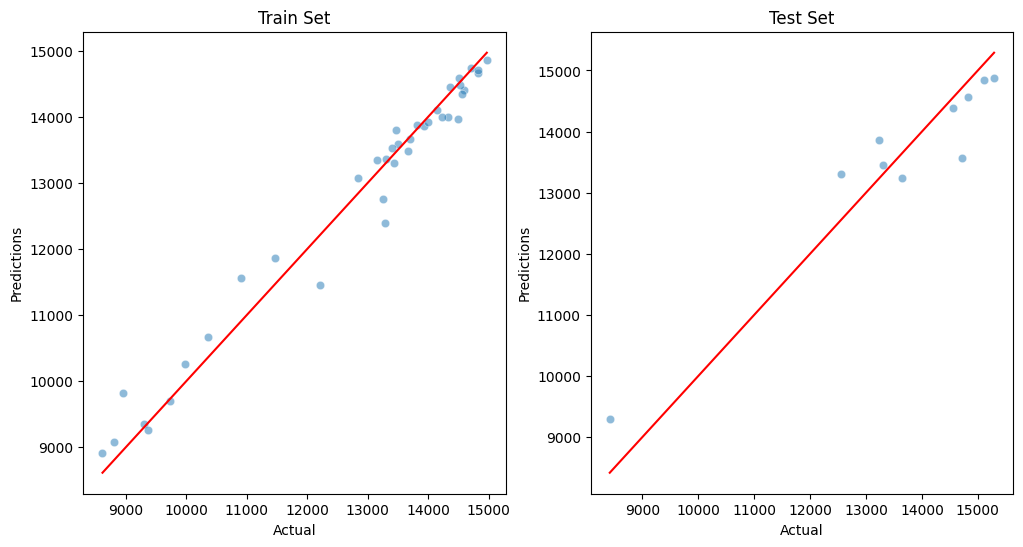

In [14]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)

In [15]:
relevant_features = ['Total Revenue', 'Total Wages', 'Insuraces', 'Transport', 'Marketing', 'Total Indirect Costs']
df_relevant = df[relevant_features]

In [16]:
df_relevant

,Total Revenue,Total Wages,Insuraces,Transport,Marketing,Total Indirect Costs
Date,,,,,,
2022-01-01,24881.70,4982.91,145.75,98.73,62.12,9304.80
2022-02-01,20864.49,4875.05,145.75,98.73,62.12,8417.75
2022-03-01,18576.09,4455.03,202.95,209.14,99.31,9727.31
2022-04-01,33879.09,5982.23,146.17,397.28,246.06,10911.03
2022-05-01,17804.99,4734.98,146.17,157.17,144.93,9359.87
2022-06-01,11875.07,4201.11,146.17,161.50,118.46,8811.23
2022-07-01,26442.30,4752.31,209.79,249.67,46.77,8953.12
2022-08-01,20922.99,4571.36,147.40,151.67,149.97,8614.86
2022-09-01,22897.23,5522.15,62.88,248.06,170.25,10364.71


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_relevant.drop(['Total Indirect Costs'], axis=1),
                                        df_relevant['Total Indirect Costs'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (38, 5) (38,) 
* Test set: (10, 5) (10,)


In [18]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        #("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

In [19]:
pipeline_ex = pipeline_random_forest_reg()
pipeline_ex.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline_ex):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline_ex)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline_ex)

def regression_evaluation(X, y, pipeline_ex):
    prediction = pipeline_ex.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline_ex.predict(X_train)
    pred_test = pipeline_ex.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.974
Mean Absolute Error: 228.761
Mean Squared Error: 103844.993
Root Mean Squared Error: 322.25


* Test Set
R2 Score: 0.931
Mean Absolute Error: 403.656
Mean Squared Error: 253703.141
Root Mean Squared Error: 503.69




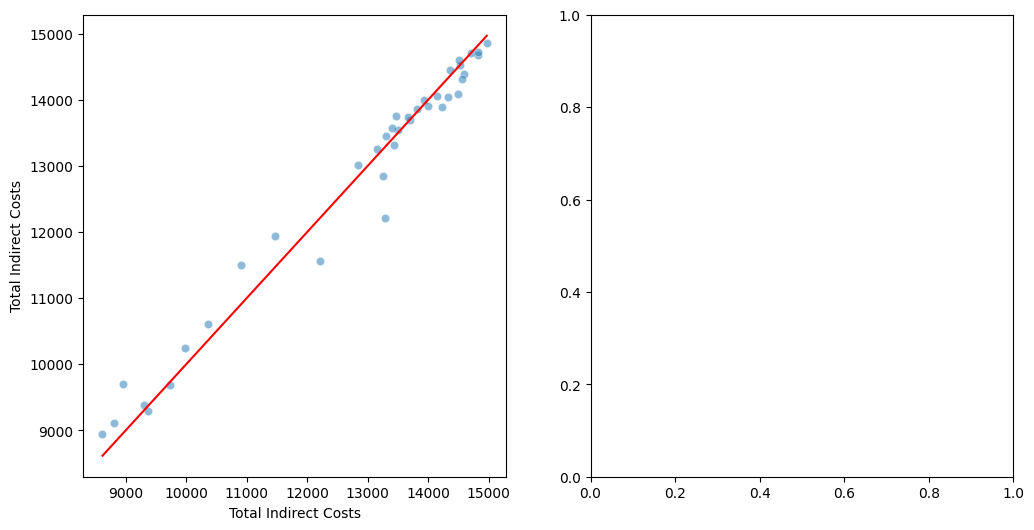

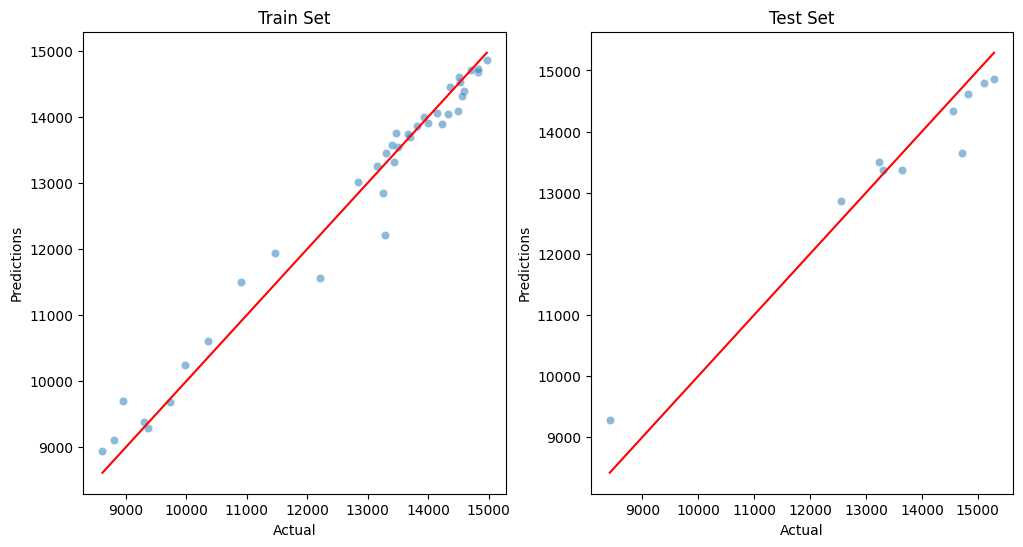

In [21]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_ex)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_ex, alpha_scatter=0.5)

In [22]:
model = 'expenses_model.pkl'
joblib.dump(pipeline_ex, model)

['expenses_model.pkl']

In [23]:
loaded_model = joblib.load('expenses_model.pkl')


### Predictive Test

In [24]:
new_data = pd.DataFrame({
    'Total Revenue': [33000],
    'Total Wages': [8797],
    'Insuraces': [213],  
    'Transport': [275],
    'Marketing': [277]
 })

# Use the model to make predictions
predicted__indirect_costs = loaded_model.predict(new_data)

# Print the predicted occupancy
print(f"Predicted Indirect Costs: ${predicted__indirect_costs[0]:.2f}")

Predicted Indirect Costs: $14632.60
